### CITS4404 Practical Project

# Camo Worms - Evolutionary Algorithm

In [2]:
# imports
from camo_worms_utils import *
from random import shuffle

In [81]:
def get_cost(image, worm_idx: int, clew: list[Camo_Worm], w_internal, w_group, w_environment):
    worm = clew[worm_idx]
    # ********************
    # internal
    
    # lets just say we want worms to be around 5 px wide
    # scale so that 5px => low score, lower or higher width => high score
    ideal = 10
    dist_from_ideal = np.abs(worm.width - ideal)

    internal_score = dist_from_ideal

    # ********************
    # group

    # count-based - get proportion of other worms "touching" this worm
    # define "touching" as dist to other point is less than this.width+other.width
    count = 0
    for i in range(len(clew)):
        if i is not worm_idx:
            # base off of three intermediate points
            # i.e. add one to count if any points are too close
            points_worm = worm.intermediate_points(math.ceil(worm.approx_length() / worm.width))
            points_other = clew[i].intermediate_points(math.ceil(clew[i].approx_length() / clew[i].width))
            
            touching = False
            for point_worm in points_worm:
                if touching:
                    count += 1
                    break
                for point_other in points_other:
                    euclid_dist = np.linalg.norm(
                        np.array(point_worm)-np.array(point_other)
                    )
                    # print(f"Points {point_worm}, {point_other}")
                    # print(f"Widths {worm.width}, {clew[i].width}")
                    # print(f"Dist {euclid_dist}\n")
                    if euclid_dist < worm.width + clew[i].width:
                        touching = True
                        break
    proportion = count/(len(clew)-1)
    print(f"Count: {count}, Proportion: {proportion}")

    group_score = proportion

    # ********************
    # environment

    # we want worms to match mean colour underneath them
    colour_score = np.abs(worm.get_mean_colour_under(image) - worm.colour)
    enviro_score = colour_score

    # return total weighted and individual scores
    return (
        internal_score*w_internal + group_score*w_group + enviro_score*w_environment,
        internal_score*w_internal,
        group_score*w_group,
        enviro_score*w_environment
    )

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


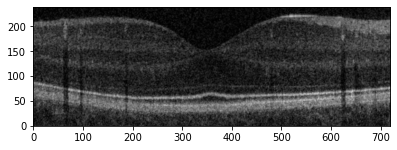

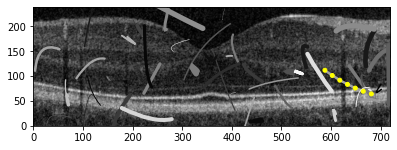

Count: 3, Proportion: 0.061224489795918366
(7.978653592457996, 7.510331422802696, 0.061224489795918366, 0.40709767985938133)


In [102]:
img = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
clew = initialise_clew(50, img.shape, (40, 30, 1))
drawing = Drawing(img)
drawing.add_worms(clew)
drawing.add_dots(clew[0].intermediate_points(), color="yellow")
drawing.show()

print(get_cost(img,0,clew, 1, 1, 1))

In [31]:
def get_fittest(image, clew: list[Camo_Worm], top_n: int, w_internal: float=1.0, w_group: float=1.0, w_environment: float=1.0):
    scores = [get_cost(image, i, clew, w_internal, w_group, w_environment) for i, worm in enumerate(clew)]
    costs = [score[0] for score in scores]
    internal_scores = [score[1] for score in scores]
    group_scores = [score[2] for score in scores]
    enviro_scores = [score[3] for score in scores]
    sorted_clew = sorted(zip(clew, costs), key=lambda x: x[1])
    return (
        [worm for worm,cost in sorted_clew[:top_n]],
        np.mean(costs),
        np.mean(internal_scores),
        np.mean(group_scores),
        np.mean(enviro_scores)
    )

In [32]:
def mutate_worm(worm: Camo_Worm):
    
    new_x = worm.x + rng.uniform(-20, 20)
    new_y = worm.y + rng.uniform(-20, 20)


    new_r = worm.r
    new_theta = worm.theta
    new_deviation_r = worm.dr
    new_deviation_gamma = worm.dgamma

    # just doing width and colour
    new_width = (worm.width + rng.uniform(-1,1))
    
    new_colour = (worm.colour + rng.uniform(-1,1))
    new_colour = max( new_colour, 0 )
    new_colour = min( new_colour, 1 )

    return Camo_Worm(new_x, new_y, new_r, new_theta, new_deviation_r, new_deviation_gamma, new_width, new_colour)

def get_next_clew(fittest: list[Camo_Worm], size: int):
    # we will keep the parents and add new worms to size
    new_clew=fittest

    # shuffle for randomness
    shuffle(fittest)
    i = 0
    while len(new_clew) < size:
        reference_worm = fittest[i]
        # mutate and add to clew
        new_worm=mutate_worm(reference_worm)
        new_clew.append(new_worm)

    return new_clew

In [33]:
def train(image, mu: int, lmbda: int, num_epochs: int=100):
    # using algorithm like https://thomasweise.github.io/aitoa/aitoa.pdf#page=114&zoom=100,94,226
    # EA no recombination
    # mu is number of parents
    # lambda is number of offspring
    # total clew = mu + lambda
    clew = initialise_clew(mu+lmbda, image.shape, (40, 30, 1))

    print("Initial")
    observe_clew(clew, image)

    for i in range(num_epochs+1):
        # get fittest mu worms
        fittest, avg_cost, avg_internal, avg_group, avg_enviro = get_fittest(image, clew, mu, w_group=10)
        # get next clew of size mu + lambda
        clew = get_next_clew(fittest.copy(), size=mu+lmbda)
        if i%20==0:
            print(60*"*")
            print(f"Epoch: {i}")
            print(f"Fittest {len(fittest)} worms\n")
            print("Average Weighted Scores")
            print("-"*30)
            print("Internal:".ljust(20) + f"{avg_internal:.4f}")
            print("Group:".ljust(20) + f"{avg_group:.4f}")
            print("Environment:".ljust(20) + f"{avg_enviro:.4f}")
            print("-"*30)
            print("Total Cost:".ljust(20) + f"{avg_cost:.4f}")
            observe_clew(fittest, image)
            print("Next Clew")
            observe_clew(clew, image)
            print(f"Worm width: {clew[0].width}")

In [1]:
img = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)
train(image=img, mu=30, lmbda=70)

NameError: name 'prep_image' is not defined

Bruh